In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.signal import hilbert, stft
%matplotlib widget

In [2]:
def convert_dataset(filename):
    DS = xr.open_dataset(filename)
    data_set = xr.Dataset()
    # data_set.coords['LAT'] = (("lat","lon"), DS.YCOR.to_numpy())
    # data_set.coords['LON'] = (("lat", "lon"), DS.XCOR.to_numpy())
    data_set.coords['lat'] = DS.YCOR.to_numpy()[:,0]
    data_set.coords['lon'] = DS.XCOR.to_numpy()[0,:]
    data_set.coords['z'] = DS.ZCOR.to_numpy()
    data_set.coords['f'] = DS.Fc.to_numpy()
    data_set = data_set.assign(totSPL=(['z', 'lat','lon'], DS.totSPL.to_numpy()))
    data_set = data_set.assign(octSPL=(['z', 'lat','lon' ,'f'], DS.octSPL.to_numpy()))

    data_set['lat'].attrs = DS.YCOR.attrs
    data_set['lon'].attrs = DS.XCOR.attrs
    data_set['z'].attrs = DS.ZCOR.attrs
    data_set['f'].attrs = DS.Fc.attrs
    data_set['totSPL'].attrs = DS.totSPL.attrs
    data_set['octSPL'].attrs = DS.octSPL.attrs


    # data_set.to_netcdf(os.path.join(outpath, os.path.basename(filename)))
    return data_set


In [3]:
def init_wfs():
    # No params, initializes the weighting function xarrays
    # Output is dictionary of xarrays corresponding of weighting functions, in dB, f is in Hz
    freq_np = np.arange(0.01, 1000, 0.01) # in kHz

    # Low frequency weighting function
    # citation: NMFS 2018
    a = 1
    b = 2
    f1 = 0.2
    f2 = 19
    C = 0.13
    W_LF = C+ 10*np.log10(((freq_np/f1)**(2*a))/(((1+(freq_np/f1)**2)**a)*((1+(freq_np/f2)**2)**b)))
    W_LF = xr.DataArray(W_LF, coords={'f': freq_np*1000}) # in Hz

    # Mid frequency weighting function
    # citation: NMFS 2018
    a = 1.6
    b = 2
    f1 = 8.8
    f2 = 110
    C = 1.20
    W_MF = C+ 10*np.log10(((freq_np/f1)**(2*a))/(((1+(freq_np/f1)**2)**a)*((1+(freq_np/f2)**2)**b)))
    W_MF = xr.DataArray(W_MF, coords={'f': freq_np*1000})   # in Hz

    # High frequency weighting function
    # citation: NMFS 2018       
    a = 1.8
    b = 2
    f1 = 12
    f2 = 140
    C = 1.36
    W_HF = C+ 10*np.log10(((freq_np/f1)**(2*a))/(((1+(freq_np/f1)**2)**a)*((1+(freq_np/f2)**2)**b)))
    W_HF = xr.DataArray(W_HF, coords={'f': freq_np*1000})  # in Hz

    # Phocid pinnipeds weighting function
    # citation: NMFS 2018
    a = 1
    b = 2
    f1 = 1.9
    f2 = 30
    C = 0.75
    W_PW = C+ 10*np.log10(((freq_np/f1)**(2*a))/(((1+(freq_np/f1)**2)**a)*((1+(freq_np/f2)**2)**b)))
    W_PW = xr.DataArray(W_PW, coords={'f': freq_np*1000})  # in Hz

    # Otariid pinnipeds weighting function
    # citation: NMFS 2018
    a = 2
    b = 2
    f1 = 0.94
    f2 = 25
    C = 0.64
    W_OW = C+ 10*np.log10(((freq_np/f1)**(2*a))/(((1+(freq_np/f1)**2)**a)*((1+(freq_np/f2)**2)**b)))
    W_OW = xr.DataArray(W_OW, coords={'f': freq_np*1000})  # in Hz

    weighting_functions = {"LFC":W_LF, "MFC":W_MF, "HFC":W_HF, "PPW":W_PW, "OPW":W_OW}
    return(weighting_functions)

# ==========================================================================
# Peak sound pressure level (SPL_pk)
# ==========================================================================


def SPL_pk_dB(y):
    # Equaltion 2 from Wilfod et al 2021
    # Assumes the value is in same units as reference value [uPa for pressure, nm/s for velocity]
    # y = originally sampled time series
    # Output is in dB re 1 uPa for pressure or re 1 nm/s for velocity
    if len(y) > 0:
        SPL_pk = 10 * np.log10(np.max(y**2))
        return float(SPL_pk)
    else:
        return np.nan


# ==========================================================================
# Root mean square Sound Pressure Level (SPL_rms)
# ==========================================================================


def SPL_rms_dB(y, dt):
    # Equaltion 1 from Wilfod et al 2021
    # Assumes the value of y is in same units as reference value [uPa for pressure, nm/s for velocity]
    # y = originally sampled time series
    # dt = time step of originally sampled time series (in s)
    # Output is in dB re 1 uPa or re 1 nm/s
    if len(y) > 0:
        T = len(y) * dt
        rms_SPL_dB = 20 * np.log10(np.sqrt((1 / T) * np.trapz(y**2, dx=dt)))
        return rms_SPL_dB
    else:
        return np.nan


# ==========================================================================
# Sound Exposure Level (SEL)
# ==========================================================================


def SEL_dB(y, dt):
    # Assumes the value of y is in same units as reference value [uPa for pressure, nm/s for velocity]
    # y = originally sampled time series
    # dt = time step of originally sampled time series (in s)
    # Output is in dB re 1 uPa * s  or dB re 1 nm/s * s
    if len(y) > 0:
        SEL = 10 * np.log10(np.trapz(y**2, dx=dt))
        return SEL
    else:
        return np.nan
    
# ==========================================================================
# Calculate all metrics from original frequency spectrum; transmission loss dictionary, and weighting functions
# ==========================================================================
def calc_all_metrics(f_og_db, w_fxn):
    """
    Parameters:
    f_og_db = frequency xarray of original frequency domain in dB; one dimension must be called f (frequency, in Hz).  1 Hz resolution, from 0-1023 Hz. 
    w_fxn = weighting function xarray by frequency; one dimension must be called f (frequency, in Hz), higher resolution and coverage than f_og_db is better   
    
    Outputs:
    returns dictionary of metrics of rmsSPL, peakSPL, SEL, both weighted and unweighted, all in dB
    """
    # Reshape appropriate weighting function to match same shape as f_og_db
    w_fxn_sub = w_fxn.sel(f=f_og_db['f'],  method = "nearest")

    # Calculate frequency resolution of transmission loss 
    # freqs = [int(x.replace("TL", "")) for x in list(TL_dict.keys())]
    # freqs.sort()
    # freq_resolution = freqs[1]- freqs[0]

    # # Produce modified spectra at point of interest (f_mod_dB) based on tranmission loss step function
    # f_mod_db = f_og_db.copy()
    # for key in TL_dict.keys():
    #     freq = int(key.replace("TL", ""))
    #     f1, f2 = int(freq-freq_resolution/2), int(freq+freq_resolution/2)
    #     TL = TL_dict[key] # in dB
    #     f_mod_db[f1:f2] = f_og_db[f1:f2]-TL
    
    # Apply weighting functions to modified spectra
    f_mod_db_w = xr.DataArray(w_fxn_sub.values + f_og_db.values, coords={'f': f_og_db['f']}) 

    # Turn f_mod and f_mod_w into uPa from dB
    f_mod_w = 10**(f_mod_db_w.real/20)
    f_mod = 10**(f_og_db.real/20)

    # inverse fft to switch into time domain for both the modified and weighted modified spectra
    # f_mod is array of uPa from 0-1023 Hz at 1 Hz intervals
    fs = 2048 # sampling frequency, in Hz
    # get time series of flat modified spectrum
    f_mod_double = np.concatenate((f_mod, np.flipud(f_mod)))
    t_mod = np.real(np.fft.ifft(f_mod_double))
    time_coords = np.arange(0,len(t_mod))/fs
    t_mod_xr = xr.DataArray(t_mod, coords={'time': time_coords}) 

    # get time series of weighted modified spectrum
    f_mod_double_w = np.concatenate((f_mod_w, np.flipud(f_mod_w)))
    t_mod_w = np.real(np.fft.ifft(f_mod_double_w))
    t_mod_xr_w = xr.DataArray(t_mod_w, coords={'time': time_coords}) 

    dt = 1/fs # time step, in s
    metrics = {}
    metrics['SPL_rms_flat'] = SPL_rms_dB(t_mod_xr, dt)
    metrics['SPL_rms_weighted'] = SPL_rms_dB(t_mod_xr_w, dt)
    metrics['SPL_pk_flat'] = SPL_pk_dB(t_mod_xr)
    metrics['SPL_pk_weighted'] = SPL_pk_dB(t_mod_xr_w)
    metrics['SEL_flat'] = SEL_dB(t_mod_xr, dt)
    metrics['SEL_weighted'] = SEL_dB(t_mod_xr_w, dt)

    return metrics

In [4]:
paracousti_path = "H:\Projects\C1308_SEAT\SEAT_inputs\plugin-input\Paracousti_files\Device_Present"
paracousti_files = [os.path.join(paracousti_path, i) for i in os.listdir(paracousti_path) if i.endswith('.nc')]
# for filename in paracousti_files:
filename = paracousti_files[0]


In [20]:
DS

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 119, z: 16, f: 9)
Coordinates:
  * lat      (lat) float32 44.54 44.55 44.55 44.55 44.55 ... 44.6 44.6 44.6 44.6
  * lon      (lon) float32 -124.3 -124.3 -124.3 -124.3 ... -124.2 -124.2 -124.2
  * z        (z) float32 4.9 9.9 14.9 19.9 24.9 ... 59.9 64.9 69.9 74.9 79.9
  * f        (f) float32 25.12 31.62 39.81 50.12 63.1 79.43 100.0 125.9 158.5
Data variables:
    totSPL   (z, lat, lon) float32 75.87 76.69 77.12 76.57 ... nan nan nan nan
    octSPL   (z, lat, lon, f) float32 42.38 57.45 64.21 58.77 ... nan nan nan

In [5]:
# DS = xr.open_dataset(filename)
DS = convert_dataset(filename)


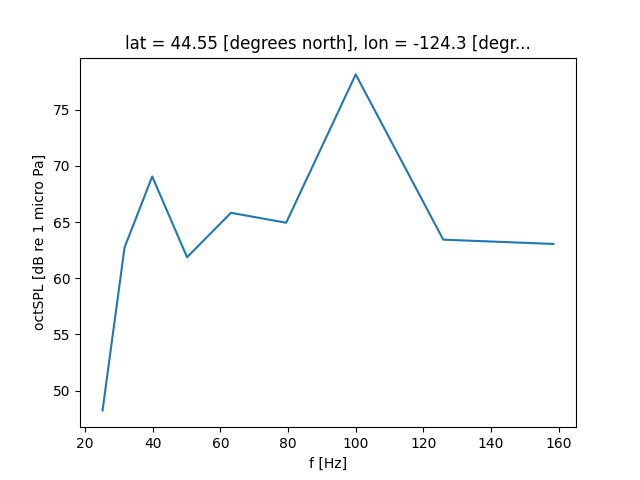

In [19]:
fig,ax = plt.subplots()
DS.octSPL.isel(lat=10, lon=10, z=0).plot(ax=ax)

In [6]:
f_new = np.arange(0,1024)
SPL_interp = DS.octSPL.interp(f=f_new)
SPL_interp = xr.where(np.isnan(SPL_interp), 0, SPL_interp)


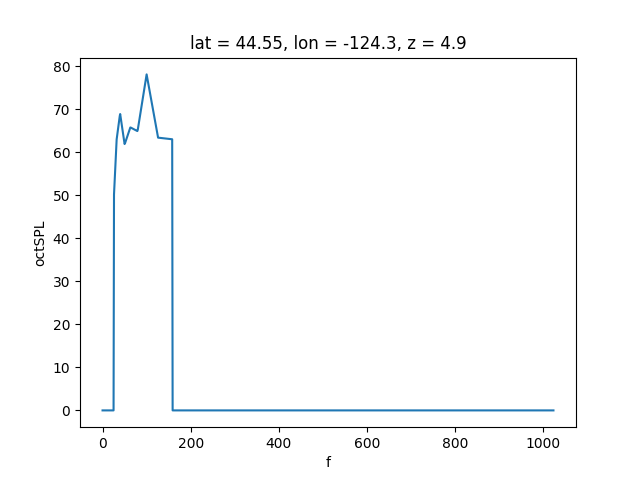

In [7]:
fig,ax = plt.subplots()
SPL_interp.isel(lat=10, lon=10, z=0).plot(ax=ax)

In [8]:
WFX = init_wfs()
WFX

{'LFC': <xarray.DataArray (f: 99999)>
 array([-25.90144613, -19.91322336, -16.44482964, ..., -68.7224702 ,
        -68.72264386, -68.72281752])
 Coordinates:
   * f        (f) float64 10.0 20.0 30.0 40.0 50.0 ... 1e+06 1e+06 1e+06 1e+06,
 'MFC': <xarray.DataArray (f: 99999)>
 array([-93.02345455, -83.39052183, -77.75564676, ..., -37.24878428,
        -37.24895591, -37.24912755])
 Coordinates:
   * f        (f) float64 10.0 20.0 30.0 40.0 50.0 ... 1e+06 1e+06 1e+06 1e+06,
 'HFC': <xarray.DataArray (f: 99999)>
 array([-109.49053033,  -98.65346691,  -92.31420894, ...,  -32.96408964,
         -32.96426   ,  -32.96443036])
 Coordinates:
   * f        (f) float64 10.0 20.0 30.0 40.0 50.0 ... 1e+06 1e+06 1e+06 1e+06,
 'PPW': <xarray.DataArray (f: 99999)>
 array([-44.82519329, -38.80495715, -35.2837382 , ..., -60.17245858,
        -60.17263215, -60.17280571])
 Coordinates:
   * f        (f) float64 10.0 20.0 30.0 40.0 50.0 ... 1e+06 1e+06 1e+06 1e+06,
 'OPW': <xarray.DataArray (f: 99999)>
 arr

In [9]:
from tqdm import trange
shape_out = (len(SPL_interp.lat), len(SPL_interp.lon), len(SPL_interp.z))
Metrics = {'SPL_rms_flat': np.zeros(shape=shape_out),
  'SPL_rms_weighted':  np.zeros(shape=shape_out),
  'SPL_pk_flat':  np.zeros(shape=shape_out),
  'SPL_pk_weighted':  np.zeros(shape=shape_out),
  'SEL_flat':  np.zeros(shape=shape_out),
  'SEL_weighted':  np.zeros(shape=shape_out)}
for ilat in trange(len(SPL_interp.lat)):
    for ilon in range(len(SPL_interp.lon)):
        for iz in range(len(SPL_interp.z)):
            metric = calc_all_metrics(f_og_db=SPL_interp.isel(lat=ilat, lon=ilon, z=iz), w_fxn=WFX['LFC'])
            for key in metric.keys():
                Metrics[key][ilat,ilon,iz] = metric[key]

100%|██████████| 120/120 [11:25<00:00,  5.71s/it]


In [10]:
#TODO MAKE Dictionary into Xarray

In [11]:
Metrics.keys()

dict_keys(['SPL_rms_flat', 'SPL_rms_weighted', 'SPL_pk_flat', 'SPL_pk_weighted', 'SEL_flat', 'SEL_weighted'])

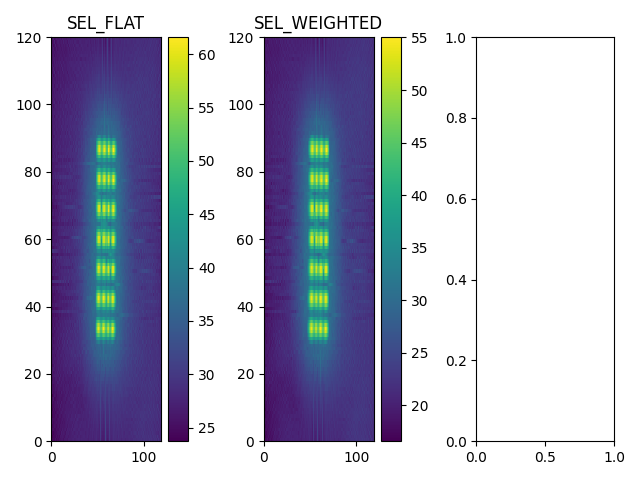

In [12]:
fig,ax = plt.subplots(ncols=3)
h0 = ax[0].pcolormesh(Metrics['SEL_flat'][:,:,0]); ax[0].set_title('SEL_FLAT'); plt.colorbar(h0, ax=ax[0])
h1 = ax[1].pcolormesh(Metrics['SEL_weighted'][:,:,0]); ax[1].set_title('SEL_WEIGHTED'); plt.colorbar(h1, ax=ax[1])
# h2 = ax[2].pcolormesh(Metrics['SEL_weighted'][:,:,0]-Metrics['SEL_flat'][:,:,0]); ax[2].set_title('WEIGHTED - FLAT'); plt.colorbar(h2, ax=ax[2])
fig.tight_layout()

# depth average and depth max

In [13]:
Metrics_Depth_Average = {k:[] for k in Metrics.keys()}
Metrics_Depth_Max = {k:[] for k in Metrics.keys()}
for key in metric.keys():
    Metrics_Depth_Average[key] = np.nanmean(Metrics[key], axis=2)
    Metrics_Depth_Max[key] = np.nanmax(Metrics[key], axis=2)

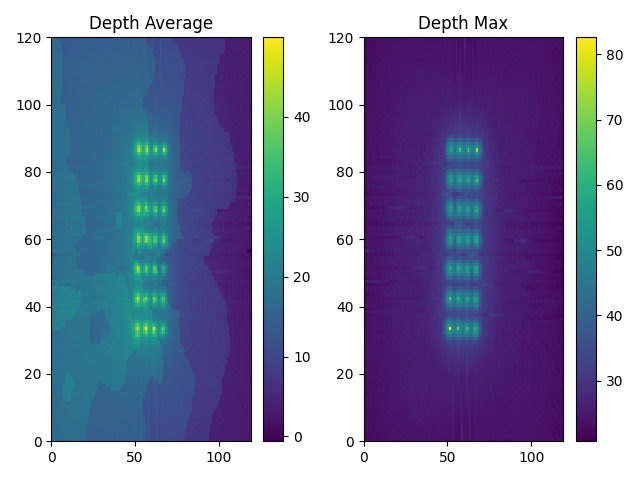

In [14]:
fig,ax = plt.subplots(ncols=2)
h0=ax[0].pcolormesh(Metrics_Depth_Average['SEL_weighted']); plt.colorbar(h0, ax=ax[0]); ax[0].set_title('Depth Average')
h1=ax[1].pcolormesh(Metrics_Depth_Max['SEL_weighted']); plt.colorbar(h1, ax=ax[1]); ax[1].set_title('Depth Max')
fig.tight_layout()

In [15]:
Metrics_Depth_Average

{'SPL_rms_flat': array([[21.89076267, 22.47070568, 22.68639088, ...,  8.07844186,
          7.12598275,  7.19539473],
        [22.59952261, 21.94184789, 22.73936794, ...,  7.12587048,
          7.02035305,  7.30116505],
        [22.8762668 , 22.71645981, 22.16986777, ...,  6.95548376,
          7.52101667,  7.2322815 ],
        ...,
        [22.56425026, 22.97083762, 21.98156715, ...,  7.24736655,
          8.15300013,  7.32532641],
        [22.76152874, 22.21807195, 22.30364808, ...,  7.84397538,
          7.19443786,  7.84406324],
        [22.5268579 , 22.28293805, 23.69728429, ...,  7.71936619,
          7.65331889,  7.23710609]]),
 'SPL_rms_weighted': array([[15.94615264, 16.4995714 , 16.73417831, ...,  3.43881177,
          2.56618448,  2.54251972],
        [16.63774761, 16.0493323 , 16.74109422, ...,  2.55159438,
          2.42559046,  2.71989785],
        [16.82721997, 16.68325588, 16.25755059, ...,  2.40931022,
          2.89061716,  2.65208173],
        ...,
        [16.643070

In [16]:
def set_axis_font(axes, fontsize=8):
    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        try: tick.label2.set_fontsize(fontsize)
        except: pass

    for tick in axes.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        try: tick.label2.set_fontsize(fontsize)
        except: pass

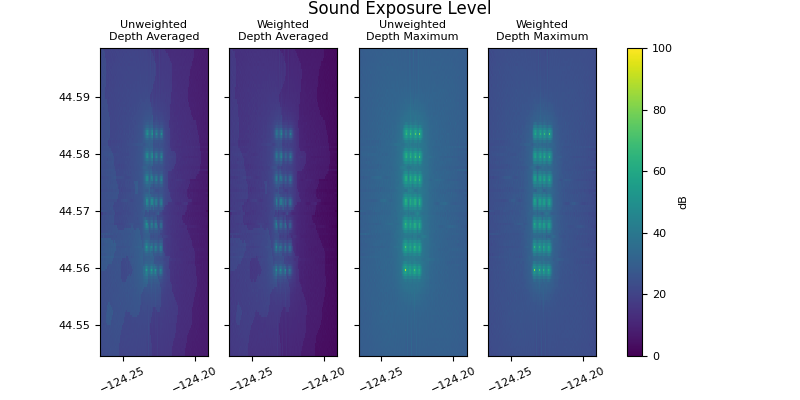

In [17]:
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(8,4))

vmin=0; vmax=100
h0=ax[0].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SEL_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h0, ax=ax[0,0]); ax[0,0].set_title('Depth Average')
h1=ax[1].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SEL_weighted'], vmin=vmin, vmax=vmax); #plt.colorbar(h1, ax=ax[0,1]); ax[0,1].set_title('Depth Average')
h2=ax[2].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SEL_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h2, ax=ax[0,2]); ax[0,2].set_title('Depth Max')
h3=ax[3].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SEL_weighted'], vmin=vmin, vmax=vmax); 
cb = plt.colorbar(h3, ax=ax); 
cb.set_label('dB', fontsize=8)
cb.ax.tick_params(labelsize=8)
ax[0].set_title('Unweighted\nDepth Averaged', fontsize=8)
ax[1].set_title('Weighted\nDepth Averaged', fontsize=8)
ax[2].set_title('Unweighted\nDepth Maximum', fontsize=8)
ax[3].set_title('Weighted\nDepth Maximum', fontsize=8)
fig.suptitle('Sound Exposure Level', y=1)
# for axis in ax[0,:]:
#     axis.set_xticklabels([])
for axis in ax[1:].ravel():
    axis.set_yticklabels([])
for axis in ax.ravel():
    set_axis_font(axis, fontsize=8)
    plt.setp( axis.xaxis.get_majorticklabels(), rotation=25 );

In [18]:
SPL

NameError: name 'SPL' is not defined

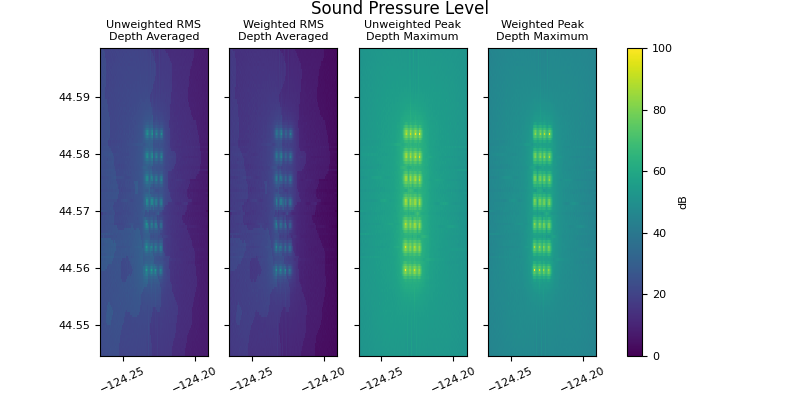

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(8,4))

vmin=0; vmax=100
h0=ax[0].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SPL_rms_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h0, ax=ax[0,0]); ax[0,0].set_title('Depth Average')
h1=ax[1].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SPL_rms_weighted'], vmin=vmin, vmax=vmax); #plt.colorbar(h1, ax=ax[0,1]); ax[0,1].set_title('Depth Average')
h2=ax[2].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SPL_pk_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h2, ax=ax[0,2]); ax[0,2].set_title('Depth Max')
h3=ax[3].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SPL_pk_weighted'], vmin=vmin, vmax=vmax); 
cb = plt.colorbar(h3, ax=ax); 
cb.set_label('dB', fontsize=8)
cb.ax.tick_params(labelsize=8)
ax[0].set_title('Unweighted RMS\nDepth Averaged', fontsize=8)
ax[1].set_title('Weighted RMS\nDepth Averaged', fontsize=8)
ax[2].set_title('Unweighted Peak\nDepth Maximum', fontsize=8)
ax[3].set_title('Weighted Peak\nDepth Maximum', fontsize=8)
fig.suptitle('Sound Pressure Level', y=1)
# for axis in ax[0,:]:
#     axis.set_xticklabels([])
for axis in ax[1:].ravel():
    axis.set_yticklabels([])
for axis in ax.ravel():
    set_axis_font(axis, fontsize=8)
    plt.setp( axis.xaxis.get_majorticklabels(), rotation=25 );

In [ ]:

vmin=0; vmax=100
h4=ax[1,0].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SPL_rms_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h4, ax=ax[1,0]); ax[1,0].set_title('Depth Average')
h5=ax[1,1].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Average['SPL_rms_weighted'], vmin=vmin, vmax=vmax); #plt.colorbar(h5, ax=ax[1,1]); ax[1,1].set_title('Depth Average')
h6=ax[1,2].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SPL_pk_flat'], vmin=vmin, vmax=vmax); #plt.colorbar(h6, ax=ax[1,2]); ax[1,2].set_title('Depth Max')
h7=ax[1,3].pcolormesh(SPL_interp.lon, SPL_interp.lat, Metrics_Depth_Max['SPL_pk_weighted'], vmin=vmin, vmax=vmax); #plt.colorbar(h7, ax=ax[1,3]); ax[1,3].set_title('Depth Max')


for axis in ax[0,:]:
    axis.set_xticklabels([])
for axis in ax[:,1:].ravel():
    axis.set_yticklabels([])

# fig.tight_layout()

In [ ]:
Metrics_Depth_Average.keys()

dict_keys(['SPL_rms_flat', 'SPL_rms_weighted', 'SPL_pk_flat', 'SPL_pk_weighted', 'SEL_flat', 'SEL_weighted'])